# Peter and the Wolf: Reinforcement Learning Primer
In this tutorial, we will learn how to apply Reinforcement learning to a problem of path finding. The setting is inspired by Peter and the Wolf musical fairy tale by Russian composer Sergei Prokofiev. It is a story about young pioneer Peter, who bravely goes out of his house to the forest clearing to chase a wolf. We will train machine learning algorithms that will help Peter to explore the surrounding area and build an optimal navigation map.

First, let's import a bunch of useful libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Overview of Reinforcement Learning
Reinforcement Learning (RL) is a learning technique that allows us to learn an optimal behaviour of an agent in some environment by running many experiments. An agent in this environment should have some goal, defined by a reward function

## The Environment
For simplicity, let's consider Peter's world to be a square board of size width x height. Each cell in this board can either be:

ground, on which Peter and other creatures can walk
water, on which you obviously cannot walk
a tree or grass - a place where you can rest
an apple, which represents something Peter would be glad to find in order to feed himself
a wolf, which is dangerous and should be avoided
To work with the environment, we will define a class called Board. In order not to clutter this notebook too much, we have moved all code to work with the board into separate rlboard module, which we will now import. You may look inside this module to get more details about the internals of the implementation.

Let's now create a random board and see how it looks:

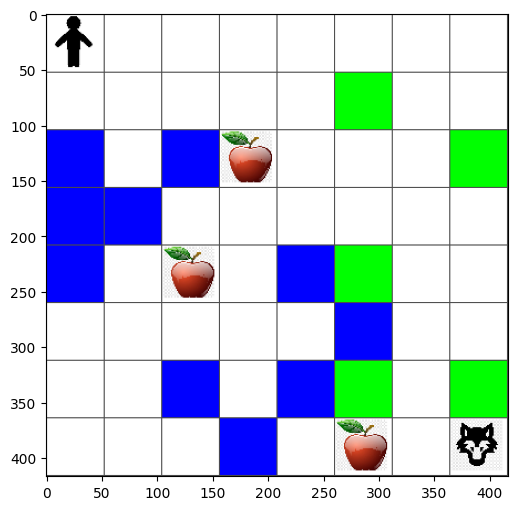

In [3]:
from rlboard import *

width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

# Actions and Policy
In our example, Peter's goal would be to find an apple, while avoiding the wolf and other obstacles. Define those actions as a dictionary, and map them to pairs of corresponding coordinate changes.

In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Implement the random walk with the below code:

In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

The call to walk should return the length of the corresponding path, which can vary from one run to another.

Run the walk experiment a number of times (say, 100), and print the resulting statistics (code block 4):

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


Note that the average length of a path is around 30-40 steps, which is quite a lot, given the fact that the average distance to the nearest apple is around 5-6 steps.

You can also see what Peter's movement looks like during the random walk:

## Reward Function
To make our policy more intelligent, we need to understand which moves are "better" than others.

In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

An interesting thing about reward functions is that in most cases, we are only given a substantial reward at the end of the game. This means that our algorithm should somehow remember "good" steps that lead to a positive reward at the end, and increase their importance. Similarly, all moves that lead to bad results should be discouraged.

## Q-Learning
Build a Q-Table, or multi-dimensional array. Since our board has dimensions width x height, we can represent Q-Table by a numpy array with shape width x height x len(actions):

In [9]:
Q = np.ones((width, height, len(actions)), dtype=float) * 1.0 / len(actions)


Pass the Q-Table to the plot function in order to visualize the table on the board:

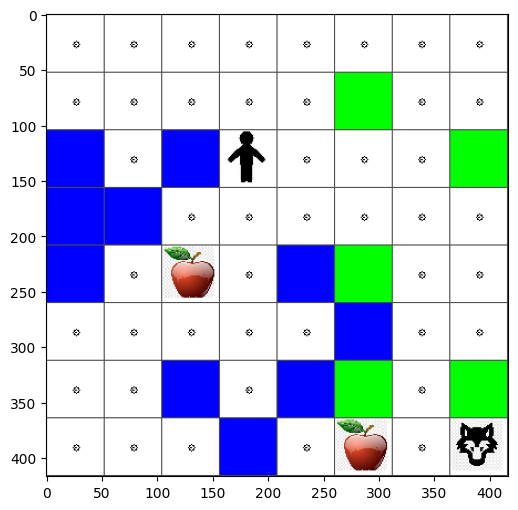

In [10]:
m.plot(Q)

## Essence of Q-Learning: Bellman Equation and Learning Algorithm
Write a pseudo-code for our leaning algorithm:

Initialize Q-Table Q with equal numbers for all states and actions
Set learning rate 
Repeat simulation many times
Start at random position
Repeat
Select an action 
 at state 
Exectute action by moving to a new state 
If we encounter end-of-game condition, or total reward is too small - exit simulation
Compute reward 
 at the new state
Update Q-Function according to Bellman equation: 
Update total reward and decrease 
.

## Exploit vs. Explore
The best approach is to balance between exploration and exploitation. As we learn more about our environment, we would be more likely to follow the optimal route, however, choosing the unexplored path once in a while.

## Python Implementation
Now we are ready to implement the learning algorithm. Before that, we also need some function that will convert arbitrary numbers in the Q-Table into a vector of probabilities for corresponding actions:

In [11]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

We add a few eps to the original vector in order to avoid division by 0 in the initial case, when all components of the vector are identical.

Run them learning algorithm through 5000 experiments, also called epochs: (code block 8)

In [ ]:
from IPython.display import clear_output

lpath = []

for epoch in range(5000):
    
    # Pick initial point
    m.random_start()
        
 # Start travelling
    n=0
    cum_reward = 0
    while True:
            x,y = m.human
            v = probs(Q[x,y])
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
            r = reward(m)
            cum_reward += r
            if r==end_reward or cum_reward < -1000:
                lpath.append(n)
                break
            alpha = np.exp(-n / 10e5)
            gamma = 0.5
            ai = action_idx[a]
            Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
            n+=1